# Tutorial for fitting sinusoidal nonhomogeneous Poisson processes (NHPPs)

This tutorial demonstrates how to fit to data the sinusoidal NHPP model with arrival rate
\begin{equation}
\lambda(t)=c_{0}+\sum_{k=1}^{p}c_{k}\cos(2\pi\nu_{k}t+\phi_{k})
\end{equation}
from the paper [Can customer arrival rates be modelled by sine waves?](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3125120) (forthcoming joint issue in *Service Science* and *Stochastic Systems*).

The frequencies $\nu_1,\cdots,\nu_p$ can take on any values in a pre-specified band $[-B,+B]$, and $\phi_k \in [0,2\pi)$ and $c_k$ are respectively the phase and amplitude of the $k$-th sinusoid. The number of sinusoids $p$ will be estimated from data.

The details of the estimation procedure is described in Appendix A of the paper. In turn, the procedure is a simpler variant of the one proposed in [Super-resolution estimation of cyclic arrival rates](https://projecteuclid.org/journals/annals-of-statistics/volume-47/issue-3/Super-resolution-estimation-of-cyclic-arrival-rates/10.1214/18-AOS1736.full) (*Annals of Statistics* 2019).

In [2]:
import pandas as pd
import numpy as np
import help_funcs
import matplotlib.pyplot as plt

Read in a simulated arrivals dataset consisting of arrival timestamps over the course of 365 days ($T=365$). The data is generated according to the NHPP model in Section 3 of the paper, with $\alpha = 3$. To keep this illustrative dataset to a reasonable size, we scale down the arrival rate used in the paper by a factor of 10 in order to reduce the number of simulated arrivals.  

In [3]:
arrivals = pd.read_csv('simulated_arrivals.csv')
arrivals.head()

,arrival_time_in_days
0,0.002607
1,0.003344
2,0.003906
3,0.005658
4,0.008437


Use the `center_periodogram()` function from the `help_funcs` module to identify the frequencies $\nu_1,\cdots,\nu_p$ in the arrivals data. This corresponds to equation (12) and Figure 4 in Appendix A of the paper.


The `center_periodogram()` function accepts the following arguments:
- `T`: Length of the observation window ($T=365$ days in the example)
- `a`: Average arrival rate, `obs`/`T`
- `obs`: The arrival timestamps as a $1\times N$ numpy array
- `freq_grid`: The grid of frequencies used to sample the periodogram. The spacing of the grid needs to be asymptotically smaller than order $1/T$. In this example we use a resolution of $1/(T\log T)$

In [4]:
obs = arrivals.arrival_time_in_days.values.reshape((1, -1))
T = 365
a = obs.size / T

max_freq = 6 #in this example, this means a maximum frequency of 6 cycles per day
freq_resolution = T*np.log(T)
freq_grid = np.linspace( 0, max_freq, num=int( max_freq*freq_resolution ) ).reshape((1, -1))

The periodogram may take some time to run, especially for large datasets.

In [5]:
windowed_periodogram = help_funcs.center_periodogram(T, obs, freq_grid, a)

Graph the periodogram to visualize the frequencies present in the arrivals data, and their amplitudes.

Text(0, 0.5, 'Amplitude')

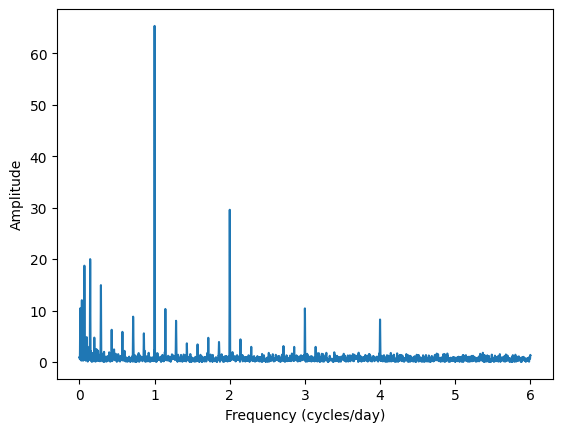

In [6]:
plt.plot(freq_grid.flatten(), windowed_periodogram.flatten())

plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")

Ignore frequencies with amplitudes below a certain noise threshold $\tau$. This represents the level of statistical noise in the frequency domain. $\tau$ can often be visually inspected. In the example above we pick $\tau = 6$.

For frequencies with amplitudes larger than $\tau$, we use the `lse_time_cont()` function from the `help_funcs` module to fit the amplitudes $c_k$'s and phases $\phi_k$'s.

In [7]:
tau = 6

constant, fitted_params = help_funcs.lse_time_cont(
    obs, windowed_periodogram, freq_grid, tau, T
)

The estimated constant ($c_0$) is:

In [8]:
print(constant)

[499.47365932]


The remainder of the estimated parameters are given in the table below with columns:
- `freq`: The frequency $\nu_k$
- `amplitude`: The amplitude $c_k$
-  `phase`: The phase $\phi_k$

In [9]:
fitted_params.index = fitted_params.index + 1
fitted_params

,freq,amplitude,phase
1,0.428671,25.188744,2.561518
2,0.043192,26.401593,-1.489375
3,1.285548,32.063521,-0.199238
4,3.999690,31.074860,-3.113582
5,0.714297,33.282714,0.519425
6,1.142968,40.924155,-0.438199
7,2.999768,42.331432,-0.798639
8,0.010682,42.733883,-0.228305
9,0.032046,45.467567,0.382237
10,0.285626,61.313541,2.970336


Now that we have the estimated parameters, we can plot the estimated arrival rate against the true arrival rate for the first 30 days.

In [10]:
pc_truth = pd.read_csv("PC_truth.csv")
def sine_estimate(t, constant, fitted_params):
    return constant.item() + np.sum(
        fitted_params.amplitude *
        np.cos(2 * np.pi * fitted_params.freq * t + fitted_params.phase)
    ).item()
pc_truth["sine_estimate"] = [sine_estimate(x, constant, fitted_params)
                       for x in pc_truth["shift"]]

Text(0, 0.5, 'Arrivals/Day')

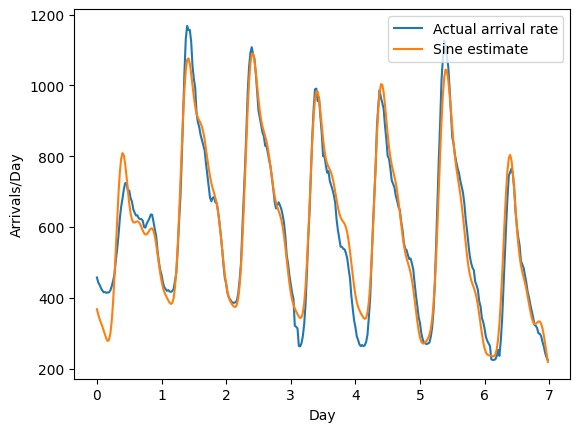

In [13]:
fig, ax = plt.subplots()
pc_truth[pc_truth["shift"] < 7].plot(x = "shift", y = ["rate", "sine_estimate"],
                                      ax=ax)
ax.legend(["Actual arrival rate", "Sine estimate"])
ax.set_xlabel("Day")
ax.set_ylabel("Arrivals/Day")